### New Deep BSDE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# ========== Hyperparameters ==========
T = 1.0
N = 40
dt = T / N
batch_size = 256
dim = 4  # state = (X, P, D, B)

# ========== Model Parameters ==========
mu_P = 0.0
sigma_P = 0.2
sigma_D = 0.15
sigma_B = 0.1
rho = 0.3
gamma = 0.05  # permanent impact
eta = 0.1     # temporary impact
c_prod = 45.0  # production cost

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== Neural Networks ==========
class ZNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + 1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 3)  # output shape matches dW dim
        )

    def forward(self, t, y):
        inp = torch.cat([t, y], dim=1)
        return self.net(inp)


class QNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + 1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, t, y):
        inp = torch.cat([t, y], dim=1)
        return self.net(inp)


# ========== Impact Functions ==========
def psi(q): return gamma * q
def phi(q): return eta * q

# ========== Generator ==========
def generator(y, q):
    P = y[:, 1:2]  # mid-price
    sign_q = torch.sign(q)
    P_exec = P + sign_q * psi(q) + phi(q)
    return -q * P_exec  # shape: (batch, 1)

# ========== Terminal Cost ==========
def terminal_cost(y, X, D):
    B = y[:, 3:4]
    I = X - D
    I_plus = torch.clamp(I, min=0.0)
    I_minus = torch.clamp(-I, min=0.0)
    return -c_prod * 0.0 + I_plus * B - I_minus * B  # zero production for now

# ========== BSDE Solver ==========
class DeepBSDE(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.Y0 = nn.Parameter(torch.tensor([[0.0]], device=device))
        self.z_net = ZNetwork(state_dim).to(device)
        self.q_net = QNetwork(state_dim).to(device)

    def forward(self):
        # Initial state (X, P, D, B)
        y = torch.zeros(batch_size, dim, device=device)
        t = torch.zeros(batch_size, 1, device=device)
        X, P, D, B = [torch.zeros(batch_size, 1, device=device) for _ in range(4)]

        Y = self.Y0.repeat(batch_size, 1)
        losses = []

        for i in range(N):
            t_input = t.clone()
            z = self.z_net(t_input, y)
            q = self.q_net(t_input, y)
            f = generator(y, q)

            dW = torch.randn(batch_size, 3, device=device) * np.sqrt(dt)
            dWP = dW[:, 0:1]
            dWD = dW[:, 1:2]
            dWB = dW[:, 2:3]

            # Forward SDE updates
            dX = q * dt
            dP = (mu_P + gamma * q) * dt + sigma_P * dWP
            dD = rho * sigma_D * dWP + np.sqrt(1 - rho**2) * sigma_D * dWD
            dB = sigma_B * dWB

            X = X + dX
            P = P + dP
            D = D + dD
            B = B + dB
            y = torch.cat([X, P, D, B], dim=1)

            Y = Y - f * dt + (z * dW).sum(dim=1, keepdim=True)
            t += dt

        terminal = terminal_cost(y, X, D)
        loss = torch.mean((Y - terminal)**2)
        return loss


# ========== Training ==========
model = DeepBSDE(state_dim=dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1000):
    optimizer.zero_grad()
    loss = model()
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.10f}")


Epoch 0: Loss = 0.0640456751
Epoch 50: Loss = 0.0004371659
Epoch 100: Loss = 0.0000895493
Epoch 150: Loss = 0.0000241537
Epoch 200: Loss = 0.0000132664
Epoch 250: Loss = 0.0000123295
Epoch 300: Loss = 0.0000095502
Epoch 350: Loss = 0.0000084259
Epoch 400: Loss = 0.0000087891
Epoch 450: Loss = 0.0000064451
Epoch 500: Loss = 0.0000078242
Epoch 550: Loss = 0.0000076746
Epoch 600: Loss = 0.0000065515
Epoch 650: Loss = 0.0000079219
Epoch 700: Loss = 0.0000067921
Epoch 750: Loss = 0.0000060670
Epoch 800: Loss = 0.0000065003
Epoch 850: Loss = 0.0000065696
Epoch 900: Loss = 0.0000066595
Epoch 950: Loss = 0.0000073405


In [41]:
def estimate_value(model, t_val, y_val):
    with torch.no_grad():
        t = torch.tensor([[t_val]], dtype=torch.float32).repeat(y_val.shape[0], 1).to(device)
        y = y_val.to(device)
        Y0 = model.Y0.repeat(y.shape[0], 1)
        return Y0.cpu().numpy()

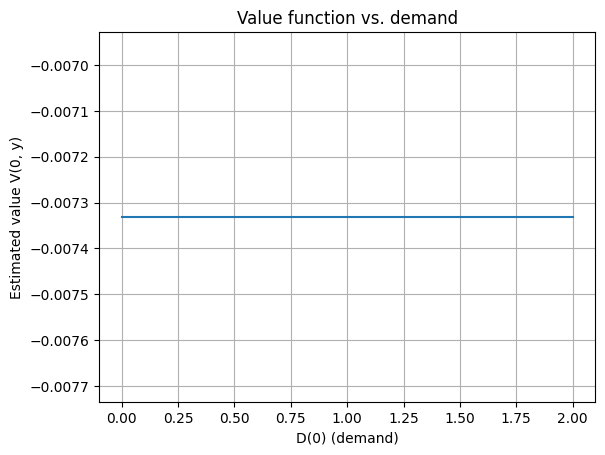

In [42]:
D_vals = torch.linspace(0.0, 2.0, 100).view(-1, 1)
X_fixed = torch.zeros_like(D_vals)
P_fixed = torch.ones_like(D_vals) * 50.0
B_fixed = torch.ones_like(D_vals) * 45.0
y_vals = torch.cat([X_fixed, P_fixed, D_vals, B_fixed], dim=1)

V0_vals = estimate_value(model, 0.0, y_vals)

import matplotlib.pyplot as plt
plt.plot(D_vals.cpu(), V0_vals)
plt.xlabel("D(0) (demand)")
plt.ylabel("Estimated value V(0, y)")
plt.title("Value function vs. demand")
plt.grid(True)
plt.show()

In [11]:
def estimate_control(model, t_val, y_val):
    with torch.no_grad():
        y_val = y_val.to(device)
        t = torch.full((y_val.shape[0], 1), t_val, dtype=torch.float32, device=device)
        return model.q_net(t, y_val).cpu().numpy()

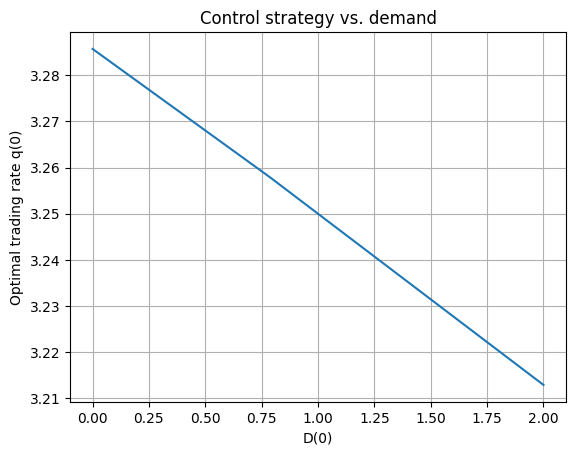

In [12]:
q_vals = estimate_control(model, 0.0, y_vals)

plt.plot(D_vals.cpu(), q_vals)
plt.xlabel("D(0)")
plt.ylabel("Optimal trading rate q(0)")
plt.title("Control strategy vs. demand")
plt.grid(True)
plt.show()

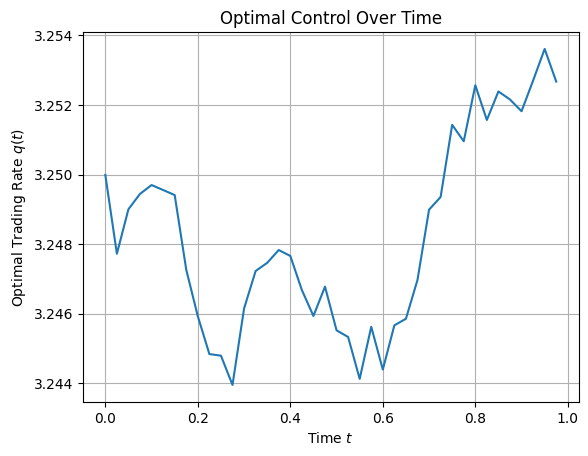

In [44]:
def simulate_control_path(model, y0=None, seed=42):
    torch.manual_seed(seed)
    model.eval()

    # Initial state
    if y0 is None:
        y = torch.tensor([[0.0, 50.0, 1.0, 45.0]], dtype=torch.float32, device=device)  # (X, P, D, B)
    else:
        y = y0.clone().to(device)

    X, P, D, B = y[:, 0:1], y[:, 1:2], y[:, 2:3], y[:, 3:4]
    t = torch.zeros(1, 1, device=device)

    q_traj = []
    t_traj = []

    for i in range(N):
        t_input = t.clone()
        q = model.q_net(t_input, y).detach().cpu().numpy()[0, 0]

        q_traj.append(q)
        t_traj.append(t.item())

        # Simulate forward SDE
        dW = torch.randn(1, 3, device=device) * np.sqrt(dt)
        dWP = dW[:, 0:1]
        dWD = dW[:, 1:2]
        dWB = dW[:, 2:3]

        dX = q * dt
        dP = (mu_P + gamma * q) * dt + sigma_P * dWP
        dD = rho * sigma_D * dWP + np.sqrt(1 - rho**2) * sigma_D * dWD
        dB = sigma_B * dWB

        X = X + dX
        P = P + dP
        D = D + dD
        B = B + dB
        y = torch.cat([X, P, D, B], dim=1)
        t += dt

    return t_traj, q_traj

t_vals, q_vals = simulate_control_path(model, seed=np.random.randint(0, 100))

import matplotlib.pyplot as plt
plt.plot(t_vals, q_vals)
plt.xlabel("Time $t$")
plt.ylabel("Optimal Trading Rate $q(t)$")
plt.title("Optimal Control Over Time")
plt.grid(True)
plt.show()